# Data-driven Decisions in Ads Campaign Optimization:
# A/B Test Like Your Life Depends on It

## Setups

In [1]:
# !pip install pandas numpy matplotlib ggplot statsmodels tqdm
# !git clone https://github.com/cstorm125/kbank_alchemists
# !mv kbank_alchemists/* .
# !ls

## Imports

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tqdm import trange

DATA_PATH = 'data/avazu/'

## First Look at The Data

We use data from Kaggle's [Click-Through Rate Prediction](https://www.kaggle.com/c/avazu-ctr-prediction/data) competition organized by [Avazu](http://avazuinc.com/home/). The data includes 10-day worth of ads-level click-through data on an hourly level. The data fields are:

* id: ad identifier
* click: 0/1 for non-click/click
* hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
* C1 -- anonymized categorical variable
* banner_pos
* site_id
* site_domain
* site_category
* app_id
* app_domain
* app_category
* device_id
* device_ip
* device_model
* device_type
* device_conn_type
* C14-C21 -- anonymized categorical variables

We randomly sampled the first 500k rows of data for this notebook in order to save time for live demonstration but you can download the entire data at Kaggle link above.

In [3]:
main_df = pd.read_csv(f'{DATA_PATH}mini.csv')
print(main_df.shape)
print(main_df.columns)
main_df.head()

(500000, 24)
Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


## Define The Problem

We want to find our if the click-through rates of ads are different for:
* Midnight to 2am vs 3am to 5am
* Banner position `0` vs `1`
* Device type `4` vs `5`
* App Category `07d7df22` vs `0f2161f8`

## Clean

It is a little distracting to be working with an entire data frame containing all variables including those you might not need right now so we are going to subset them and work with a slighly smaller one.

In [4]:
df = main_df[['click','hour','banner_pos','device_type','app_category']].copy()
df.head()

,click,hour,banner_pos,device_type,app_category
0,0,14102100,0,1,07d7df22
1,0,14102100,0,1,07d7df22
2,0,14102100,0,1,07d7df22
3,0,14102100,0,1,07d7df22
4,0,14102100,1,1,07d7df22


We also need to convert `hour` to a categorical variable for `midnight to 2am` and `3am to 5am`

In [5]:
df['daynight'] = df['hour'].map(lambda x: 0 if int(str(x)[-2:]) < 3 else 1)
df.head()

,click,hour,banner_pos,device_type,app_category,daynight
0,0,14102100,0,1,07d7df22,0
1,0,14102100,0,1,07d7df22,0
2,0,14102100,0,1,07d7df22,0
3,0,14102100,0,1,07d7df22,0
4,0,14102100,1,1,07d7df22,0


## Explore

Before going into any data project, it is useful to get to know your data. The easiest and most effective way to do so is to plot some figures. The main library for plotting in Python is `matplotlib.pyplot` that we imported as `plt`.

Looking at the distribution of the features is a sanity check for us to make sure that the groups we are comparing are of similar sizes. If that is not the case, using frequentist statistics can give spurious results. Moreover, looking at the plotted conversion by group can already give us a good idea if our test variables are actually different from one another or not.

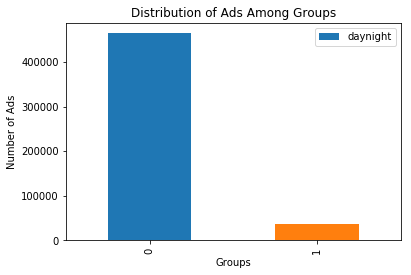

In [6]:
vc = df.daynight.value_counts()
vc.plot(kind='bar')
plt.title('Distribution of Ads Among Groups')
plt.xlabel('Groups')
plt.ylabel('Number of Ads')
plt.legend()

Text(0,0.5,'Number of Ads')

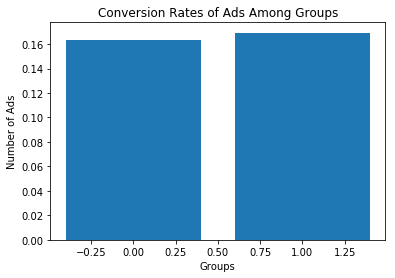

In [7]:
#why just plotting graphs could be problematic
conv = df[['daynight','click']].groupby('daynight').mean()
plt.bar(conv.index,conv.click)
plt.title('Conversion Rates of Ads Among Groups')
plt.xlabel('Groups')
plt.ylabel('Number of Ads')

Text(0,0.5,'Number of Ads')

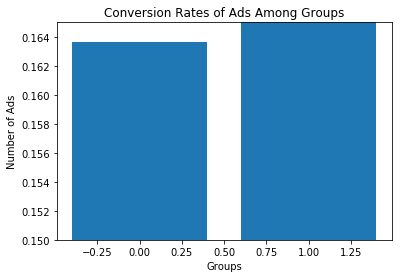

In [8]:
#why just plotting could be problematic
conv = df[['daynight','click']].groupby('daynight').mean()
plt.bar(conv.index,conv.click)
plt.axis([None, None, 0.15, 0.165])
plt.title('Conversion Rates of Ads Among Groups')
plt.xlabel('Groups')
plt.ylabel('Number of Ads')

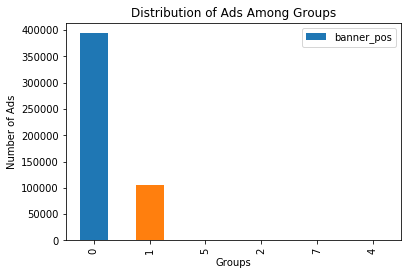

In [9]:
vc = df.banner_pos.value_counts()
vc.plot(kind='bar')
plt.title('Distribution of Ads Among Groups')
plt.xlabel('Groups')
plt.ylabel('Number of Ads')
plt.legend()

Text(0,0.5,'Number of Ads')

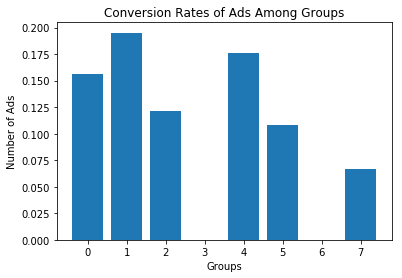

In [10]:
conv = df[['banner_pos','click']].groupby('banner_pos').mean()
plt.bar(conv.index,conv.click)
plt.title('Conversion Rates of Ads Among Groups')
plt.xlabel('Groups')
plt.ylabel('Number of Ads')

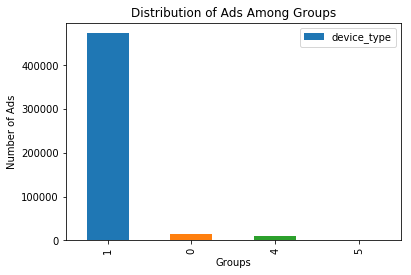

In [11]:
#less is more
vc = df.device_type.value_counts()
vc.plot(kind='bar')
plt.title('Distribution of Ads Among Groups')
plt.xlabel('Groups')
plt.ylabel('Number of Ads')
plt.legend()

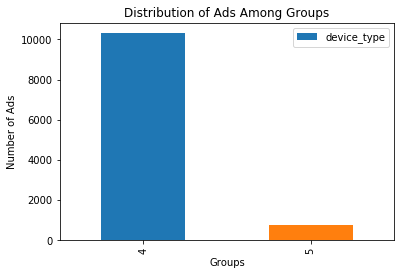

In [12]:
#less is more
vc = df[df.device_type>=4].device_type.value_counts()
vc.plot(kind='bar')
plt.title('Distribution of Ads Among Groups')
plt.xlabel('Groups')
plt.ylabel('Number of Ads')
plt.legend()

Text(0,0.5,'Number of Ads')

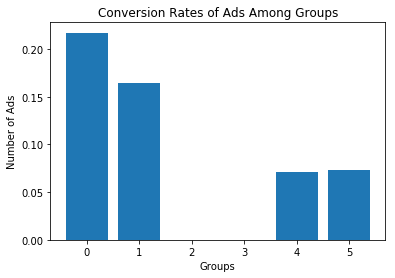

In [13]:
conv = df[['device_type','click']].groupby('device_type').mean()
plt.bar(conv.index,conv.click)
plt.title('Conversion Rates of Ads Among Groups')
plt.xlabel('Groups')
plt.ylabel('Number of Ads')

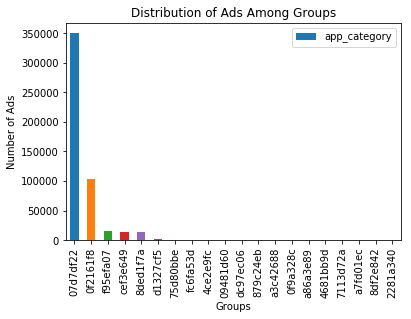

In [14]:
vc = df.app_category.value_counts()
vc.plot(kind='bar')
plt.title('Distribution of Ads Among Groups')
plt.xlabel('Groups')
plt.ylabel('Number of Ads')
plt.legend()

Text(0,0.5,'Number of Ads')

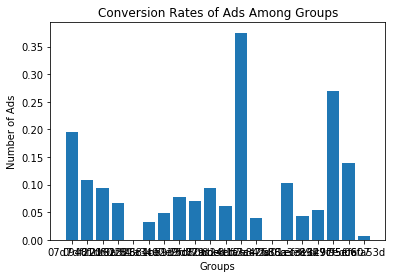

In [15]:
conv = df[['app_category','click']].groupby('app_category').mean()
plt.bar(conv.index,conv.click)
plt.title('Conversion Rates of Ads Among Groups')
plt.xlabel('Groups')
plt.ylabel('Number of Ads')

## Frequentist Hypothesis Testing

One common way to find out if two test variables are in fact different from each other is using frequentist hypothesis tests. In frequenstist statistics we use the following steps in hypotheses testing:

1. Assume that the difference in variables follow a certain distribution such as normal distribution, Student T's distribution, and so on. For conversion rates, we usually assume a Z distribution as a result of Bernoulli trials.
2. Given that assumption of distribution, we calculate the probability that we will see the actual difference that we are seeing right now and call that statistics **p-value**.
3. We use some threshold of p-value to determine if the difference we see is **statistically significant**

The hypotheses are as follows:

* Null (No-difference) Hypothesis

$H_0: p_a - p_b = 0$

* Alternative Hypothesis

$H_1: p_a - p_b \neq 0$

**Concept Assigment** Given the descirption, which one do you think the p-value of frequentist statistics is?
1. $P(\text{Hypothesis}|\text{Data})$
2. $P(\text{Data}|\text{Hypothesis})$

To learn more about p-values, see [a Medium article I translated](https://medium.com/@iwishcognitivedissonance/p-value-%E0%B8%99%E0%B8%B1%E0%B9%89%E0%B8%99%E0%B8%AA%E0%B8%B3%E0%B8%84%E0%B8%B1%E0%B8%8D%E0%B9%84%E0%B8%89%E0%B8%99-%E0%B8%84%E0%B8%A7%E0%B8%B2%E0%B8%A1%E0%B9%84%E0%B8%A1%E0%B9%88%E0%B8%A3%E0%B8%B9%E0%B9%89%E0%B9%80%E0%B8%97%E0%B9%88%E0%B8%B2%E0%B8%97%E0%B8%B1%E0%B8%99%E0%B8%AD%E0%B8%B1%E0%B8%95%E0%B8%A3%E0%B8%B2%E0%B8%9E%E0%B8%B7%E0%B9%89%E0%B8%99%E0%B8%90%E0%B8%B2%E0%B8%99-f7601c841318)

### From Scratch

In [16]:
click_a = np.sum(df[df['device_type']==4].click)
click_b = np.sum(df[df['device_type']==5].click)
obs_a = len(df[df['device_type']==4])
obs_b = len(df[df['device_type']==5])

#calculate converstion rates
conv_a = click_a / obs_a
conv_b = click_b / obs_b
#under the null hypothesis assumption these are the same
conv_null = np.mean([conv_a,conv_b])
print(f'''
Conversion of A: {conv_a}, 
Conversion of B: {conv_b}, 
Conversion under Null hypothesis: {conv_null}
''')


Conversion of A: 0.07058252427184467, 
Conversion of B: 0.0731070496083551, 
Conversion under Null hypothesis: 0.07184478694009988



In [17]:
diffs = []

for i in range(1000):
    a_converted = np.random.choice([1, 0], size=obs_a, p=[conv_null, (1-conv_null)])
    b_converted = np.random.choice([1, 0], size=obs_b, p=[conv_null, (1-conv_null)])
    diff = a_converted.mean()-b_converted.mean()
    diffs.append(diff)

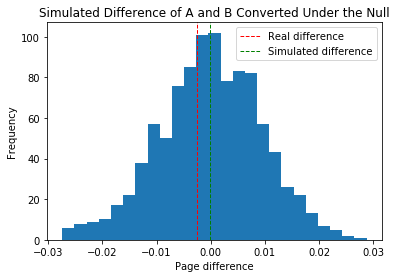

In [18]:
# Plot histogram
plt.hist(diffs, bins=25)
plt.title('Simulated Difference of A and B Converted Under the Null')
plt.xlabel('Page difference')
plt.ylabel('Frequency')
plt.axvline(x=(conv_a-conv_b), color='r', linestyle='dashed', linewidth=1, label="Real difference")
plt.axvline(x=(np.mean(diffs)), color='g', linestyle='dashed', linewidth=1, label="Simulated difference")
plt.legend()
plt.show()

### Using Statsmodels Magic

In [19]:
#device type
click_a = np.sum(df[df['device_type']==4].click)
click_b = np.sum(df[df['device_type']==5].click)
obs_a = len(df[df['device_type']==4])
obs_b = len(df[df['device_type']==5])
z_score, p_value = sm.stats.proportions_ztest(count=[click_a, click_b], 
                                                          nobs=[obs_a, obs_b],
                                                        alternative='two-sided')
print(f'''
Conversion of A: {click_a/obs_a}, 
Conversion of B: {click_b/obs_b}, 
Z-score: {z_score}, 
p_value: {np.round(p_value,4)}
''')


Conversion of A: 0.07058252427184467, 
Conversion of B: 0.0731070496083551, 
Z-score: -0.2628858828798043, 
p_value: 0.7926



In [20]:
?sm.stats.proportions_ztest

**Coding Assignment** Use the templates above, either from scratch or statsmodel magic, to find out about the remaining assumptions.

In [21]:
'''Write your code here'''


'Write your code here'

## Conclusion

We want to find our if the click-through rates of ads are different for:
* Midnight to 2am vs 3am to 5am
* Banner position `0` vs `1`
* Device type `4` vs `5`
* App Category `07d7df22` vs `0f2161f8`

But **by how much**? That is one question that frequentist statistics cannot answer and we might need some more tools from **bayesian statistics** to understand.